# Batching across material points

In this section, we extend the previous setup to evaluate the constitutive law for a set of $N$ material points, which we will refer to as a *batch* of size $N$. To achieve this efficiently, we leverage `jax`'s automatic vectorization via the `jax.vmap` function.

As an illustrative example, we consider perfect plasticity and perform a single evaluation of the constitutive update for strains that would lead the elastic predictor outside the yield surface. The constitutive update then projects these points back onto the yield surface. We focus on purely deviatoric strains of the form:

$$
\boldsymbol{\varepsilon} = \text{diag}(e_I, e_{II}, -(e_I + e_{II}))
$$

The batch consists of $N$ points defined by:

$$
e_I = \epsilon \cos(\theta_k), \quad e_{II} = \epsilon \sin(\theta_k), \quad \theta_k \in [0, 2\pi], \quad k = 1,\dots,N
$$

where the amplitude $\epsilon$ is chosen sufficiently large to exceed the plastic yield surface.

We first represent $\boldsymbol{\varepsilon}$ as a batched `SymmetricTensor2` with shape `(N, 3, 3)`. By convention, the batch dimension is always the first axis.

In [1]:
import matplotlib.pyplot as plt
import jax

jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import equinox as eqx
import jaxmat.materials as jm
from jaxmat.tensors import SymmetricTensor2

N = 40
theta = jnp.linspace(0, jnp.pi, N)

eps_ = 2e-3
eps = jnp.zeros((N, 3, 3))
eps = eps.at[:, 0, 0].set(eps_ * jnp.cos(theta))
eps = eps.at[:, 1, 1].set(eps_ * jnp.sin(theta))
eps = eps.at[:, 2, 2].set(-eps[:, 0, 0] - eps[:, 1, 1])
eps = SymmetricTensor2(tensor=eps)

Next, we define an elastoplastic material based on `GeneralIsotropicHardening`, which allows us to consider different yield surfaces. Here, we choose a Hosford surface and will vary its shape parameter $a$. The yield stress is nearly constant to mimic perfect plasticity.

In [2]:
sig0 = 300.0


class YieldStress(eqx.Module):
    sig0: float
    H_: float = 1e-6

    def __call__(self, p):
        return self.sig0 * (1.0 + self.H_ * p)


material = jm.GeneralIsotropicHardening(
    elastic_model=jm.LinearElasticIsotropic(E=200e3, nu=0),
    yield_stress=YieldStress(sig0=sig0),
    plastic_surface=jm.Hosford(),
)

We then initialize the state for all $N$ points:

In [3]:
state = material.init_state(Nbatch=N)

To evaluate the constitutive behavior over the entire batch, we vectorize the constitutive update using the `jax.vmap` transform. The method signature is `(material, strain, state, dt)`, so `in_axes=(None, 0, 0, None)` specifies that only the first axes of `strain` and `state` are vectorized, while `material` and the time step `dt` are shared across the batch.

In [4]:
batched_constitutive_update = jax.vmap(
    jm.GeneralIsotropicHardening.constitutive_update, in_axes=(None, 0, 0, None)
)

```{attention}
We vectorize the **unbound class method** `GeneralIsotropicHardening.constitutive_update` rather than the bound method `material.constitutive_update`. This approach is more general, allowing different instances of the same material to be used without redefining the batched constitutive update.
```

Next, we iterate over different values of the Hosford parameter $a$. Using equinox.tree_at, we update the material PyTree to define a new material instance, then evaluate the batched constitutive update for the batch of strains and states. The resulting batched stress tensors are then plotted on the deviatoric $\pi$-plane.

In [5]:
def scatter_pi_plane(stress, marker="o", **kwargs):
    from jaxmat.tensors import eigenvalues

    eigvals = jax.vmap(eigenvalues, in_axes=0)(stress)
    xx = jnp.concatenate([eigvals[:, i] - eigvals[:, (i + 2) % 3] for i in range(3)])
    xx = jnp.concatenate((xx, -xx)) * jnp.sqrt(3) / 2
    yy = jnp.concatenate([eigvals[:, (i + 1) % 3] for i in range(3)])
    yy = jnp.concatenate((yy, yy)) * 3 / 2
    plt.scatter(xx, yy, marker=marker, **kwargs)
    margin = 0.1
    lim = (1 + margin) * sig0
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.gca().set_aspect("equal")

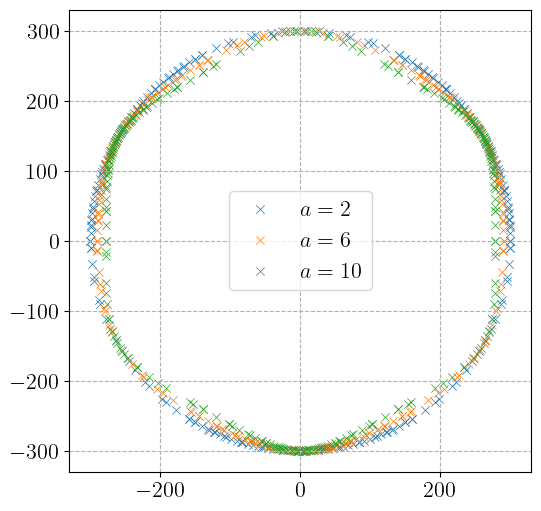

In [6]:
plt.figure(figsize=(6, 6))
dt = 0.0
for i, a in enumerate([2.0, 6.0, 10.0]):
    material = eqx.tree_at(lambda m: m.plastic_surface.a, material, jnp.asarray(a))
    stress, new_state = batched_constitutive_update(material, eps, state, dt)
    scatter_pi_plane(stress, "x", color=f"C{i}", linewidth=0.5, label=rf"$a={int(a)}$")
plt.legend()
plt.show()